In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [3]:
data_dir_train = "/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Train"
data_dir_test = "/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Test"
data_dir_val= "/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Val"


In [4]:

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
}

train_dataset= datasets.ImageFolder(root=data_dir_train, transform=data_transforms["train"])
val_dataset =datasets.ImageFolder(root=data_dir_val, transform=data_transforms["val"])
test_dataset= datasets.ImageFolder(root=data_dir_test, transform=data_transforms["test"])
train_loader= DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader =DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


class_names =train_dataset.classes
num_classes =len(class_names)


In [14]:

checkpoint_path ="/kaggle/input/k10-class/best_model_vit_16_tiny_pretrain_epoch_70.pth"
checkpoint =torch.load(checkpoint_path)

# model = VisionTransformer(
#     img_size=224, 
#     patch_size=16, 
#     in_channels=3, 
#     num_classes=10, 
#     embed_dim=384, 
#     depth=6, 
#     num_heads=6, 
#     mlp_ratio=4.0
# ).to(device)
model=create_vit_model(10).to(device)
model.load_state_dict(checkpoint)
model.eval()  #á


/tmp/ipykernel_30/2325564612.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [15]:
from sklearn.metrics import confusion_matrix
import numpy as npnum_classes

# Tạo DataLoader cho tập test
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Tạo danh sách lưu nhãn thực tế và nhãn dự đoán
y_true = []
y_pred = []

# Vòng lặp qua tập kiểm tra
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Dự đoán
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Lấy nhãn dự đoán có xác suất cao nhất
        
        # Lưu nhãn vào danh sách
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


Confusion Matrix:
[[ 224   23    0   29    0    0    0   28    4   29]
 [   6  349    0   18    1    0    1   14   12   20]
 [   0    2  615    3    4    2    0    0    2    0]
 [  10   35    0  167    1    0    0   25    4   11]
 [   0    0    0    0  642    8   15    0    0    0]
 [   0    1   24    0    8 1517   44    0    0    0]
 [   0    0    1    0   35   18  363    0    0    0]
 [  14   24    0   31    0    1    0  306    5   31]
 [  10   37    1    7    0    2    9    7  270   28]
 [   8   13    0   21    1    1    0   24   10  263]]


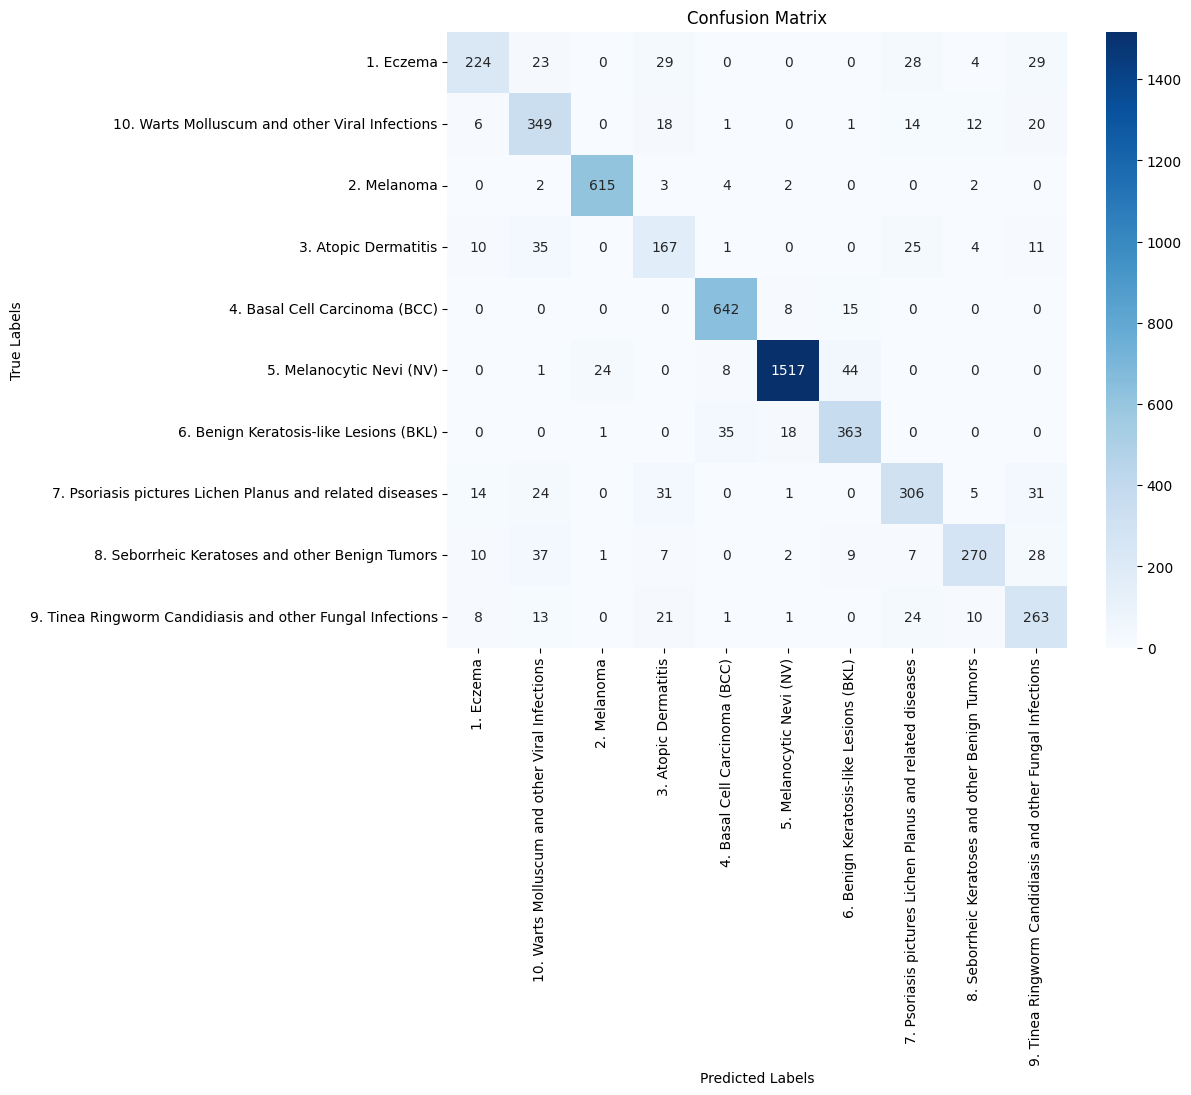

In [16]:

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
vdfcvsv

In [ ]:
print(class_names) 

In [ ]:

from collections import Counter

def plot_class_distribution(dataset, class_names):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    class_indices = list(class_counts.keys())
    class_values = list(class_counts.values())
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[class_names[idx] for idx in class_indices], y=class_values, palette="viridis")
    plt.title("Class Distribution in Training Data", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, class_names)


In [ ]:
plot_class_distribution(val_dataset, class_names)


In [ ]:
from torch.utils.data import WeightedRandomSampler

class_sample_counts= Counter([label for _, label in train_dataset])
weights = 1./np.array([class_sample_counts[i] for i in range(num_classes)])
sample_weights=[weights[label]for _, label in train_dataset]

# Sampler
sampler=WeightedRandomSampler(sample_weights,len(sample_weights),replacement=True)
train_loader= DataLoader(train_dataset,batch_size=64,sampler=sampler,num_workers=2)


In [ ]:

data_iter =iter(train_loader)
images,labels=next(data_iter)
fig,ax= plt.subplots(nrows=3,ncols=10,figsize=(20, 8))
for idx in range(30):
    row,col =divmod(idx, 10)
    ax[row,col].imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
    ax[row,col].set_title(str(class_names[labels[idx]]), fontsize=8)
    ax[row,col].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# # Tính trọng số cho các lớp
# y_train = [label for _, labels in train_loader for label in labels.numpy()]
# class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")



In [ ]:
# def create_vgg_model(num_classes):
#     model = models.vgg16(pretrained=True)
#     model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
#     return model


In [ ]:
# def create_resnet_model(num_classes):
#     model = models.resnet50(pretrained=True)
#     model.fc = nn.Linear(model.fc.in_features, num_classes)
#     return model


In [10]:
import timm

# def create_xception_model(num_classes):
#     model = timm.create_model("xception", pretrained=True)
#     model.fc = nn.Linear(model.fc.in_features, num_classes)
#     return model


In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size=img_size
        self.patch_size=patch_size
        self.num_patches=(img_size // patch_size)**2
        self.proj=nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        B, C, H, W =x.shape
        assert H ==self.img_size and W== self.img_size, "Kích thước ảnh không đúng."
        x =self.proj(x)  # [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

class MultiHeadSelfAttention(nn.Module):
    """Lớp Self-Attention đa đầu."""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads=num_heads
        self.embed_dim=embed_dim
        self.head_dim=embed_dim // num_heads
        assert self.head_dim * num_heads==embed_dim, "embed_dim không chia hết cho num_heads."

        self.qkv=nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.attn_drop=nn.Dropout(0.1)
        self.proj =nn.Linear(embed_dim, embed_dim)
        self.proj_drop= nn.Dropout(0.1)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, num_heads, N, head_dim]

        attn =(q @ k.transpose(-2, -1)) * (1.0 / self.head_dim**0.5)
        attn= attn.softmax(dim=-1)
        attn= self.attn_drop(attn)

        x =(attn @ v).transpose(1, 2).reshape(B, N, C)
        x= self.proj(x)
        x =self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 =nn.LayerNorm(embed_dim)
        self.attn =MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2= nn.LayerNorm(embed_dim)

        hidden_dim= int(embed_dim * mlp_ratio)
        self.mlp= nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = x+self.attn(self.norm1(x))
        x = x +self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000, 
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.xavier_uniform_(self.head.weight)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1 + num_patches, embed_dim]
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        cls_output = x[:, 0]  # [B, embed_dim]
        x = self.head(cls_output)
        return x

# # Khởi tạo mô hình
num_classes = 10   # Số lớp cần phân loại
model_from_scratch = VisionTransformer(
    img_size=224, 
    patch_size=16, 
    in_channels=3, 
    num_classes=num_classes, 
    embed_dim=384, 
    depth=6, 
    num_heads=6, 
    mlp_ratio=4.0
).to(device)

# # Hiển thị cấu trúc mô hình
# print(model_from_scratch)


In [ ]:
# def count_parameters(model):
#     """Tính tổng số lượng tham số trong mô hình."""
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# # Tính số lượng tham số
# num_params = count_parameters(model_from_scratch)
# print(f"Số lượng tham số trong mô hình: {num_params:,}")


In [ ]:
# checkpoint = torch.load("/kaggle/working/check/checkpointtiny.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']
# print(checkpoint['optimizer_state_dict'])


In [7]:
def create_vit_model(num_classes):
    model = timm.create_model("vit_tiny_patch16_224", pretrained=False, img_size=224)
    model.head = nn.Linear(model.head.in_features, 10)
    return model


In [ ]:
def create_vit_model(num_classes=10, freeze_backbone=False):
    # Tải mô hình ViT với pre-trained weights
    model = timm.create_model("vit_tiny_patch16_224", pretrained=True, img_size=224)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad =False
    model.head =nn.Linear(model.head.in_features, 10)

    for param in model.head.parameters():
        param.requires_grad =True

    return model


In [ ]:
def train_and_evaluate_with_wandb(model, dataloaders, criterion, optimizer, device, num_epochs):
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        wandb.log({"epoch": epoch + 1})
        
        model.train()
        running_loss, running_corrects = 0.0, 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                loss.backward()
                optimizer.step()
                total_norm=0
                for p in model.parameters():
                    if p.grad is not None:
                        total_norm += p.grad.norm().item() ** 2
                total_norm = total_norm ** 0.5
                wandb.log({"grad_norm": total_norm})

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            # Log hình ảnh từ batch đầu tiên
            if batch_idx ==0:
                images = wandb.Image(inputs[:8].cpu(), caption="Ground Truth: {}".format(labels[:8].cpu()))
                wandb.log({"samples": images})

        # Tính toán loss và accuracy sau pha train
        train_loss = running_loss / len(dataloaders['train'].dataset)
        train_acc = running_corrects.double() /len(dataloaders['train'].dataset)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.item())
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": train_acc.item()
        })

        print(f"Train Loss:{train_loss:.4f} Acc:{train_acc:.4f}")

        # Pha validation chỉ chạy mỗi 5 epoch
        if epoch % 5== 4:
            model.eval()
            running_loss, running_corrects = 0.0, 0

            for batch_idx,(inputs, labels) in enumerate(dataloaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.set_grad_enabled(False):
                    outputs= model(inputs)
                    loss =criterion(outputs, labels)
                    _, preds =torch.max(outputs, 1)

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            # Tính toán loss và accuracy sau pha validation
            val_loss = running_loss / len(dataloaders['val'].dataset)
            val_acc = running_corrects.double() / len(dataloaders['val'].dataset)

            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc.item())
            wandb.log({
                "val_loss": val_loss,
                "val_accuracy": val_acc.item()
            })

            print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            # Kiểm tra và lưu mô hình nếu val accuracy cao nhất
            if val_acc > best_val_acc:
                best_val_acc =val_acc
                model_path= f"/kaggle/working/best_model_vit_16_tiny_pretrain_epoch_{epoch + 1}.pth"  # Tên file có index của epoch
                torch.save(model.state_dict(), model_path)
                wandb.save(model_path)
                print(f"Best model saved at epoch {epoch + 1} with val accuracy {best_val_acc:.4f}")

    # Lưu mô hình cuối cùng vào Wandb
    torch.save(model.state_dict(), "final_model_custom.pth")
    wandb.save("final_model_pretrain.pth")
    print("Final model saved.")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [ ]:
import wandb
import timm

wandb.login(key="e758a83caf6b3093ddec96e020c4520e46faf29b")
# Khởi tạo Wandb
wandb.init(
    project="skin-disease-classification",
    id=" tiny stranformer for new skin data 12 8 hoanf class 10 do nhaafm 15 part2",
    config={
        "epochs": 100,
        "batch_size": 64,
        "learning_rate": 0.0003,
        "optimizer": "Adam",
        "model": "tiny stranformer 224",
        "num_classes": 10
    }
)

config = wandb.config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model_from_scratch.to(device)
model= create_vit_model(10).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
pretrain_params = []
head_params = []
for name,param in model.named_parameters():
    if "head" in name:  # Tìm các tham số của lớp head (output)
        head_params.append(param)
    else:  # Các tham số còn lại là pre-trained
        pretrain_params.append(param)

# Khởi tạo optimizer với các nhóm tham số
optimizer= torch.optim.AdamW(
    [
        {"params": pretrain_params, "lr": config.learning_rate * 0.1},  # LR nhỏ cho lớp pretrain
        {"params": head_params, "lr": config.learning_rate}  # LR lớn hơn cho lớp head
    ],
    weight_decay=1e-4
)


# Tạo dataloaders dictionary
dataloaders ={
    "train": train_loader,
    "val":val_loader
}


# checkpoint = torch.load("/kaggle/working/check/checkpointtiny3.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch']


In [ ]:
# Huấn luyện và log dữ liệu
train_and_evaluate_with_wandb(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=200
)



In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# from sklearn.metrics import average_precision_score
# import numpy as np

# def evaluate_on_test(model, dataloader, criterion, device, num_classes=10, num_samples=5):
#     """
#     Hàm đánh giá mô hình trên tập test và log số liệu lên WandB.
#     Log thêm các chỉ số như precision, recall, F1, mAP và một số mẫu đúng, sai.
#     """
#     print("Evaluating on test set...")
#     model.eval()  # Chuyển mô hình sang chế độ đánh giá
#     running_loss, running_corrects = 0.0, 0
#     all_preds = []
#     all_labels = []
#     correct_samples = []
#     incorrect_samples = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             # Dự đoán
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             _, preds = torch.max(outputs, 1)

#             # Tính toán loss và số mẫu dự đoán đúng
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#             # Lưu toàn bộ nhãn và dự đoán
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#             # Lưu mẫu đúng và sai
#             for i in range(inputs.size(0)):
#                 if preds[i] == labels[i]:
#                     if len(correct_samples) < num_samples:  # Giới hạn số lượng
#                         correct_samples.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))
#                 else:
#                     if len(incorrect_samples) < num_samples:  # Giới hạn số lượng
#                         incorrect_samples.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))

#     # Tính loss và accuracy
#     test_loss = running_loss / len(dataloader.dataset)
#     test_acc = running_corrects.double() / len(dataloader.dataset)

#     # Tính các chỉ số Precision, Recall, F1-score
#     precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
#     recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
#     f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

#     # Tính mAP (nếu số lớp > 2)
#     all_probs = torch.cat([torch.softmax(model(inputs.to(device)), dim=1) for inputs, _ in dataloader]).cpu().numpy()
#     mAP = average_precision_score(np.eye(num_classes)[all_labels], all_probs, average="weighted")

#     # Log kết quả lên WandB
#     wandb.log({
#         "test_loss": test_loss,
#         "test_accuracy": test_acc.item(),
#         "test_precision": precision,
#         "test_recall": recall,
#         "test_f1": f1,
#         "test_mAP": mAP
#     })

#     print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")
#     print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, mAP: {mAP:.4f}")

#     # Log một số mẫu đúng và sai
#     correct_images = [
#         wandb.Image(img.permute(1, 2, 0).numpy(), caption=f"Correct: True={true_label}, Pred={pred_label}")
#         for img, true_label, pred_label in correct_samples
#     ]
#     incorrect_images = [
#         wandb.Image(img.permute(1, 2, 0).numpy(), caption=f"Incorrect: True={true_label}, Pred={pred_label}")
#         for img, true_label, pred_label in incorrect_samples
#     ]

#     wandb.log({
#         "Correct Samples": correct_images,
#         "Incorrect Samples": incorrect_images
#     })

#     return test_loss, test_acc.item(), precision, recall, f1, mAP


In [ ]:

# # test_dataloader=DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# # test_loss, test_acc, precision, recall, f1, mAP = evaluate_on_test(
# #     model, test_dataloader, criterion, device, num_classes=15, num_samples=5
# # )


# # wandb.finish()
# import os

# # Tạo thư mục nếu chưa tồn tại
# save_dir = "/kaggle/working/check"
# os.makedirs(save_dir, exist_ok=True)



In [ ]:
# Lưu trạng thái mô hình và optimizer

checkpoint ={
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 100  # Số epoch đã hoàn thành
}
torch.save(checkpoint,"/kaggle/working/check/tiny trans new skin.pth")
print(1 )



In [ ]:
# checkpoint = torch.load("/kaggle/working/check/checkpointtiny2.pth", map_location=device)
# # model.load_state_dict(checkpoint['model_state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # start_epoch = checkpoint['epoch']
# print(checkpoint['optimizer_state_dict'])


In [ ]:
def count_parameters(model):
    """Tính tổng số lượng tham số trong mô hình."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Tính số lượng tham số
num_params = count_parameters(model_from_scratch)
print(f"Số lượng tham số trong mô hình: {num_params:,}")


In [ ]:
# import os
# os.remove("/kaggle/working/wandb")

In [ ]:
# # Lấy config từ Wandb
# config = wandb.config

# # Thiết lập thiết bị
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Khởi tạo mô hình và các thành phần
# model = create_vit_model(22).to(device)
# # model = model_from_scratch_2
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# # Tạo dataloaders dictionary
# dataloaders = {
#     "train": train_loader,
#     "val": val_loader
# }

In [ ]:
pretrain
Epoch 1/200
Train Loss: 1.5465 Acc: 0.4520
Epoch 2/200
Train Loss: 1.0016 Acc: 0.6131
Epoch 3/200
Train Loss: 0.8776 Acc: 0.6668
Epoch 4/200
Train Loss: 0.8040 Acc: 0.7018
Epoch 5/200
Train Loss: 0.7449 Acc: 0.7268
Val Loss: 0.6321 Acc: 0.7691
Best model saved at epoch 5 with val accuracy 0.7691
Epoch 6/200
Train Loss: 0.7007 Acc: 0.7399
Epoch 7/200
Train Loss: 0.6463 Acc: 0.7618
Epoch 8/200
Train Loss: 0.6152 Acc: 0.7772
Epoch 9/200
Train Loss: 0.5714 Acc: 0.7887
Epoch 10/200
Train Loss: 0.5390 Acc: 0.8033
Val Loss: 0.5947 Acc: 0.7949
Best model saved at epoch 10 with val accuracy 0.7949
Epoch 11/200
Train Loss: 0.5051 Acc: 0.8160
Epoch 12/200
Train Loss: 0.4852 Acc: 0.8254
Epoch 13/200
Train Loss: 0.4495 Acc: 0.8388
Epoch 14/200
Train Loss: 0.4429 Acc: 0.8419
Epoch 15/200
Train Loss: 0.4015 Acc: 0.8576
Val Loss: 0.5780 Acc: 0.8034
Best model saved at epoch 15 with val accuracy 0.8034
Epoch 16/200
Train Loss: 0.3930 Acc: 0.8591
Epoch 17/200
Train Loss: 0.3614 Acc: 0.8707
Epoch 18/200
Train Loss: 0.3521 Acc: 0.8778
Epoch 19/200
Train Loss: 0.3417 Acc: 0.8818
Epoch 20/200
Train Loss: 0.3268 Acc: 0.8858
Val Loss: 0.5479 Acc: 0.8207
Best model saved at epoch 20 with val accuracy 0.8207
Epoch 21/200
Train Loss: 0.3073 Acc: 0.8919
Epoch 22/200
Train Loss: 0.2975 Acc: 0.8963
Epoch 23/200
Train Loss: 0.2843 Acc: 0.9006
Epoch 24/200
Train Loss: 0.2733 Acc: 0.9054
Epoch 25/200
Train Loss: 0.2627 Acc: 0.9085
Val Loss: 0.5567 Acc: 0.8263
Best model saved at epoch 25 with val accuracy 0.8263
Epoch 26/200
Train Loss: 0.2566 Acc: 0.9109
Epoch 27/200
Train Loss: 0.2393 Acc: 0.9161
Epoch 28/200
Train Loss: 0.2407 Acc: 0.9154
Epoch 29/200
Train Loss: 0.2279 Acc: 0.9203
Epoch 30/200
Train Loss: 0.2170 Acc: 0.9259
Val Loss: 0.5692 Acc: 0.8384
Best model saved at epoch 30 with val accuracy 0.8384
Epoch 31/200
Train Loss: 0.2174 Acc: 0.9270
Epoch 32/200
Train Loss: 0.2140 Acc: 0.9270
Epoch 33/200
Train Loss: 0.2007 Acc: 0.9314
Epoch 34/200
Train Loss: 0.2008 Acc: 0.9303
Epoch 35/200
Train Loss: 0.1977 Acc: 0.9303
Val Loss: 0.6034 Acc: 0.8359
Epoch 36/200
Train Loss: 0.1919 Acc: 0.9346
Epoch 37/200
Train Loss: 0.1824 Acc: 0.9375
Epoch 38/200
Train Loss: 0.1748 Acc: 0.9414
Epoch 39/200
Train Loss: 0.1753 Acc: 0.9392
Epoch 40/200
Train Loss: 0.1741 Acc: 0.9412
Val Loss: 0.5994 Acc: 0.8406
Best model saved at epoch 40 with val accuracy 0.8406
Epoch 41/200
Train Loss: 0.1731 Acc: 0.9408
Epoch 42/200
Train Loss: 0.1676 Acc: 0.9425
Epoch 43/200
Train Loss: 0.1564 Acc: 0.9466
Epoch 44/200
Train Loss: 0.1570 Acc: 0.9450
Epoch 45/200
Train Loss: 0.1533 Acc: 0.9467
Val Loss: 0.5648 Acc: 0.8491
Best model saved at epoch 45 with val accuracy 0.8491
Epoch 46/200
Train Loss: 0.1488 Acc: 0.9509
Epoch 47/200
Train Loss: 0.1533 Acc: 0.9474
Epoch 48/200
Train Loss: 0.1492 Acc: 0.9488
Epoch 49/200
Train Loss: 0.1414 Acc: 0.9516
Epoch 50/200
Train Loss: 0.1385 Acc: 0.9522
Val Loss: 0.5887 Acc: 0.8502
Best model saved at epoch 50 with val accuracy 0.8502
Epoch 51/200
Train Loss: 0.1414 Acc: 0.9526
Epoch 52/200
Train Loss: 0.1364 Acc: 0.9537
Epoch 53/200
Train Loss: 0.1325 Acc: 0.9538
Epoch 54/200
Train Loss: 0.1300 Acc: 0.9557
Epoch 55/200
Train Loss: 0.1293 Acc: 0.9553
Val Loss: 0.6168 Acc: 0.8480
Epoch 56/200
Train Loss: 0.1306 Acc: 0.9547
Epoch 57/200
Train Loss: 0.1304 Acc: 0.9553
Epoch 58/200
Train Loss: 0.1264 Acc: 0.9576
Epoch 59/200
Train Loss: 0.1167 Acc: 0.9598
Epoch 60/200
Train Loss: 0.1216 Acc: 0.9585
Val Loss: 0.5806 Acc: 0.8591
Best model saved at epoch 60 with val accuracy 0.8591
Epoch 61/200
Train Loss: 0.1162 Acc: 0.9604
Epoch 62/200
Train Loss: 0.1214 Acc: 0.9573
Epoch 63/200
Train Loss: 0.1220 Acc: 0.9555
Epoch 64/200
Train Loss: 0.1160 Acc: 0.9605
Epoch 65/200
Train Loss: 0.1112 Acc: 0.9629
Val Loss: 0.5973 Acc: 0.8536
Epoch 66/200
Train Loss: 0.1159 Acc: 0.9614
Epoch 67/200
Train Loss: 0.1119 Acc: 0.9599
Epoch 68/200
Train Loss: 0.1148 Acc: 0.9600
Epoch 69/200
Train Loss: 0.1092 Acc: 0.9628
Epoch 70/200
Train Loss: 0.1055 Acc: 0.9637
Val Loss: 0.5999 Acc: 0.8565
Epoch 71/200
Train Loss: 0.1045 Acc: 0.9637
Epoch 72/200
Train Loss: 0.1015 Acc: 0.9642
Epoch 73/200
Train Loss: 0.1060 Acc: 0.9636
Epoch 74/200
Train Loss: 0.1049 Acc: 0.9626
Epoch 75/200
Train Loss: 0.0988 Acc: 0.9649
Val Loss: 0.6407 Acc: 0.8462
Epoch 76/200
Train Loss: 0.0991 Acc: 0.9666
Epoch 77/200
Train Loss: 0.0942 Acc: 0.9686
Epoch 78/200
Train Loss: 0.0978 Acc: 0.9676
Epoch 79/200
Train Loss: 0.0902 Acc: 0.9703
Epoch 80/200
Train Loss: 0.0990 Acc: 0.9660
Val Loss: 0.6377 Acc: 0.8528
Epoch 81/200
Train Loss: 0.0896 Acc: 0.9692
Epoch 82/200
Train Loss: 0.0887 Acc: 0.9706
Epoch 83/200
Train Loss: 0.0909 Acc: 0.9694
Epoch 84/200
Train Loss: 0.0965 Acc: 0.9668
Epoch 85/200
Train Loss: 0.0924 Acc: 0.9684
Val Loss: 0.6327 Acc: 0.8572
Epoch 86/200
Train Loss: 0.0918 Acc: 0.9676
Epoch 87/200
Train Loss: 0.0894 Acc: 0.9687
Epoch 88/200
Train Loss: 0.0853 Acc: 0.9714
Epoch 89/200
Train Loss: 0.0832 Acc: 0.9725
Epoch 90/200
Train Loss: 0.0941 Acc: 0.9674
Val Loss: 0.6402 Acc: 0.8576
Epoch 91/200
Train Loss: 0.0852 Acc: 0.9699
Epoch 92/200
Train Loss: 0.0906 Acc: 0.9688
Epoch 93/200
Train Loss: 0.0840 Acc: 0.9711
Epoch 94/200
Train Loss: 0.0809 Acc: 0.9725
Epoch 95/200
Train Loss: 0.0870 Acc: 0.9703
Val Loss: 0.6499 Acc: 0.8521
Epoch 96/200
Train Loss: 0.0843 Acc: 0.9704
Epoch 97/200
Train Loss: 0.0814 Acc: 0.9723
Epoch 98/200
Train Loss: 0.0827 Acc: 0.9707
Epoch 99/200
Train Loss: 0.0773 Acc: 0.9720
Epoch 100/200
Train Loss: 0.0800 Acc: 0.9720
Val Loss: 0.6268 Acc: 0.8613
Best model saved at epoch 100 with val accuracy 0.8613
Epoch 101/200
Train Loss: 0.0829 Acc: 0.9719
Epoch 102/200
Train Loss: 0.0804 Acc: 0.9718
Epoch 103/200
Train Loss: 0.0804 Acc: 0.9718
Epoch 104/200
Train Loss: 0.0723 Acc: 0.9738
Epoch 105/200
Train Loss: 0.0757 Acc: 0.9735
Val Loss: 0.6475 Acc: 0.8569
Epoch 106/200
Train Loss: 0.0779 Acc: 0.9735
Epoch 107/200
Train Loss: 0.0758 Acc: 0.9737
Epoch 108/200
Train Loss: 0.0763 Acc: 0.9726
Epoch 109/200
Train Loss: 0.0747 Acc: 0.9740
Epoch 110/200
Train Loss: 0.0721 Acc: 0.9752
Val Loss: 0.6645 Acc: 0.8620
Best model saved at epoch 110 with val accuracy 0.8620
Epoch 111/200
Train Loss: 0.0762 Acc: 0.9729
Epoch 112/200
Train Loss: 0.0795 Acc: 0.9720
Epoch 113/200
Train Loss: 0.0749 Acc: 0.9740
Epoch 114/200
Train Loss: 0.0711 Acc: 0.9756
Epoch 115/200
Train Loss: 0.0720 Acc: 0.9737
Val Loss: 0.6542 Acc: 0.8591
Epoch 116/200
Train Loss: 0.0723 Acc: 0.9751
Epoch 117/200
Train Loss: 0.0758 Acc: 0.9723
Epoch 118/200
Train Loss: 0.0692 Acc: 0.9750
Epoch 119/200
Train Loss: 0.0725 Acc: 0.9745
Epoch 120/200
Train Loss: 0.0698 Acc: 0.9750
Val Loss: 0.6550 Acc: 0.8558
Epoch 121/200
Train Loss: 0.0645 Acc: 0.9767
Epoch 122/200
Train Loss: 0.0741 Acc: 0.9743
Epoch 123/200
Train Loss: 0.0698 Acc: 0.9744
Epoch 124/200
Train Loss: 0.0657 Acc: 0.9768
Epoch 125/200
Train Loss: 0.0654 Acc: 0.9778
Val Loss: 0.6669 Acc: 0.8572
Epoch 126/200
Train Loss: 0.0657 Acc: 0.9768
Epoch 127/200
Train Loss: 0.0648 Acc: 0.9781
Epoch 128/200
Train Loss: 0.0671 Acc: 0.9774
Epoch 129/200
Train Loss: 0.0598 Acc: 0.9790
Epoch 130/200
Train Loss: 0.0658 Acc: 0.9774
Val Loss: 0.6831 Acc: 0.8554
Epoch 131/200
Train Loss: 0.0690 Acc: 0.9762
Epoch 132/200
Train Loss: 0.0652 Acc: 0.9755
Epoch 133/200
Train Loss: 0.0671 Acc: 0.9771
Epoch 134/200
Train Loss: 0.0725 Acc: 0.9736
Epoch 135/200
Train Loss: 0.0685 Acc: 0.9753
Val Loss: 0.6689 Acc: 0.8587
Epoch 136/200
Train Loss: 0.0676 Acc: 0.9760
Epoch 137/200
Train Loss: 0.0635 Acc: 0.9772
Epoch 138/200
Train Loss: 0.0613 Acc: 0.9782
Epoch 139/200
Train Loss: 0.0629 Acc: 0.9768
Epoch 140/200
Train Loss: 0.0649 Acc: 0.9763
Val Loss: 0.6584 Acc: 0.8598
Epoch 141/200
Train Loss: 0.0600 Acc: 0.9791
Epoch 142/200
Train Loss: 0.0610 Acc: 0.9762
Epoch 143/200
Train Loss: 0.0645 Acc: 0.9773
Epoch 144/200
Train Loss: 0.0584 Acc: 0.9787
Epoch 145/200
Train Loss: 0.0595 Acc: 0.9799
Val Loss: 0.6867 Acc: 0.8598
Epoch 146/200
Train Loss: 0.0647 Acc: 0.9772
Epoch 147/200
Train Loss: 0.0637 Acc: 0.9757
Epoch 148/200
Train Loss: 0.0590 Acc: 0.9787
Epoch 149/200
Train Loss: 0.0606 Acc: 0.9773
Epoch 150/200
Train Loss: 0.0545 Acc: 0.9799
Val Loss: 0.7183 Acc: 0.8554
Epoch 151/200